# QQQ 크롤링

웹 페이지는
 - 정적 웹페이지 - 클릭할게 없어서 내용이 안 바뀌는 페이지
 - 동적 웹 페이지 - 클릭하면 내용이 바뀌는 페이지

이렇게 나누어집니다

당연히 정적 웹페이지가 더 쉽고 내용도 간단해서 가져오기도 쉽습니다


저희가 가져올 페이지

https://www.schwab.wallst.com/schwab/Prospect/research/etfs/schwabETF/index.asp?type=holdings&symbol=QQQ

이 페이지 들어가보시면 

60개로보기 다음 페이지 클릭하기 이런 버튼들 있지 않습니까?

안타깝게도 이 버튼들 클릭해서 페이지가 바뀌는

동적 웹 페이지 입니다.

정적 웹페이지 크롤링은 

파이썬 코드 창에 

!pip install bs4 

이거만 실행하면 딱히 더 할건 없는데

저희가 해야하는 동적 웹페이지 크롤링은

!pip install Selenium 하는건 문제 없는데

아마도 코랩에서는 실행이 안될겁니다

아마도 driver=Chrome( ) 이 부분에서 오류 뜰 듯 합니다

로컬 환경에서 실행해야해서 그런거 같은데 

저는 아나콘다 주피터노트북으로 실행했습니다.

아나콘다 설치, 크롬드라이버 설치는 문서 하단에 첨부해두었습니다.

## 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import requests

from io import StringIO
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## 1. 크롬 창 띄우기

In [2]:
driver = Chrome()

## 2. 그 크롬 창에 웹사이트 연결하기

In [3]:
url = 'https://www.schwab.wallst.com/schwab/Prospect/research/etfs/schwabETF/index.asp?type=holdings&symbol=QQQ'
driver.get(url)

## 3. 60개로 보기 클릭

1. CTRL + SHIFT + C 눌러서 

2. 표 밑의 Show 20 40 60 PAGE의 60 클릭

3. Elements 창에 <a perpage=60 .... 이라고 되어있는 부분 오른쪽 클릭

4. copy의 Copy Xpath 클릭해서 확인하면 //*[@id="PaginationContainer"]/ul[1]/li[4]/a 이렇게 되어있음

5. 다시 파이썬 코드로 돌아가서 element 변수에 Xpath 저장 - > 클릭할 대상을 저장하는 과정

6. 그리고 element 클릭


In [4]:
element = WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.XPATH, '//*[@id="PaginationContainer"]/ul[1]/li[4]/a'))
)
element.click()

## 4. 페이지로부터 데이터프레임 읽어오기

1. page_html 에 지금 페이지의 html 텍스트 전체를 저장

2. df_list에 StringIO를 통해 html 텍스트 가공한 내용들을 저장

   df_list는 리스트 형태이긴 한데 리스트의 요소가 데이터프레임

In [5]:
page_html = driver.page_source
df_list = pd.read_html(StringIO(page_html))

In [6]:
df_list[1].head(3)

,Symbol,Description,% Portfolio Weight,Shares Held,Market Value
0,MSFT,Microsoft Corp,8.59%,53.8M,$22.0B
1,AAPL,Apple Inc,7.95%,111.9M,$20.4B
2,NVDA,NVIDIA Corp,6.39%,18.1M,$16.4B


## 5. 데이터프레임 추출

1. 사실 원래대로라면 Xpath 저장하고 그거 대로 추출하는게 정석이지만
   경험상 아무 숫자 찍어넣고 찾아보는게 훨씬 빠른듯 합니다

2. df_holdings1 에 불러온 데이터 프레임 저장

3. 날짜, 마지막 가격은 df_list[0]에 있음

4. 날짜는 iloc[1]로 추출, 마지막 가격은 iloc[0]으로 추출 후 형식 에 맞게 가공

In [7]:
df_holdings1 = df_list[1]

In [8]:
df_holdings1.head(3)

,Symbol,Description,% Portfolio Weight,Shares Held,Market Value
0,MSFT,Microsoft Corp,8.59%,53.8M,$22.0B
1,AAPL,Apple Inc,7.95%,111.9M,$20.4B
2,NVDA,NVIDIA Corp,6.39%,18.1M,$16.4B


In [9]:
df_list[0]

,Last Price,Unnamed: 1,Today's Change,Unnamed: 3,Bid/Size,Unnamed: 5,Ask/Size,Unnamed: 7,Today's Volume,Unnamed: 9
0,$442.06,NaN,+1.04 (0.24%),NaN,$441.22/1,NaN,$441.25/1,NaN,"27,116,566 Below Avg.",NaN
1,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024,As of close 05/10/2024


In [10]:
date = df_list[0]["Last Price"].iloc[1].replace("As of close\xa0", "")
last_price = float(df_list[0]["Last Price"].iloc[0].replace("$", ""))

In [11]:
last_price

442.06

In [12]:
date

'05/10/2024'

## 6. 2페이지로 넘어가기

1. element2에 < Previous 1 2 Next > 중 2번 버튼의 Xpath를 Copy Xpath를 통해 복사해서 저장

2. element2.click()으로 2페이지로 넘어가기

In [13]:
element2 = WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.XPATH, '//*[@id="PaginationContainer"]/ul[2]/li[3]/a'))
)
element2.click()


## 7. 페이지로부터 데이터프레임 읽어오기

1. page_html2 에 지금 페이지의 html 텍스트 전체를 저장

2. df_lis2t에 StringIO를 통해 html 텍스트 가공한 내용들을 저장

In [14]:
page_html2 = driver.page_source
df_list2 = pd.read_html(StringIO(page_html2))

## 8. 데이터프레임 추출


1. df_holdings2 에 불러온 데이터 프레임 저장

2. 날짜, 마지막 가격은 df_list[0]에 있음

3. 날짜는 iloc[1]로 추출, 마지막 가격은 iloc[0]으로 추출 후 형식 에 맞게 가공

In [15]:
df_holdings2 = df_list2[1]
df_holdings2.head(3)

,Symbol,Description,% Portfolio Weight,Shares Held,Market Value
0,MRNA,Moderna Inc,0.34%,7.1M,$865.4M
1,KDP,Keurig Dr Pepper Inc,0.34%,26.0M,$877.7M
2,AEP,American Electric Power Co Inc,0.34%,9.8M,$884.7M


## 9. 데이터 병합

In [16]:
df = pd.concat([df_holdings1,df_holdings2],axis=0)

In [17]:
df

,Symbol,Description,% Portfolio Weight,Shares Held,Market Value
0,MSFT,Microsoft Corp,8.59%,53.8M,$22.0B
1,AAPL,Apple Inc,7.95%,111.9M,$20.4B
2,NVDA,NVIDIA Corp,6.39%,18.1M,$16.4B
3,AMZN,Amazon.com Inc,5.53%,75.2M,$14.2B
4,META,Meta Platforms Inc Class A,4.63%,25.4M,$11.9B
...,...,...,...,...,...
37,WBD,Warner Bros. Discovery Inc Ordinary Shar...,0.14%,45.6M,$354.7M
38,ILMN,Illumina Inc,0.13%,3.0M,$335.4M
39,WBA,Walgreens Boots Alliance Inc,0.11%,16.1M,$279.9M
40,SIRI,Sirius XM Holdings Inc,0.09%,71.9M,$225.0M


## 10. 파일로 저장

csv파일은 가끔씩 오류날때가 있어서 일단 xlsx로 저장

In [18]:
df.to_excel('QQQ.xlsx',index=False)

## 크롬 드라이버 설치

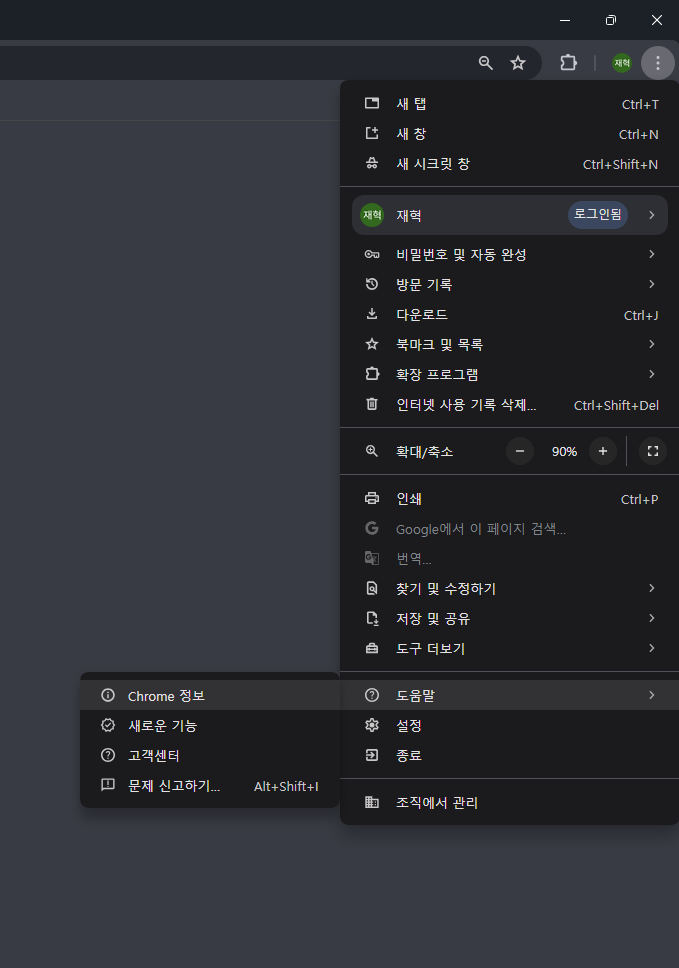

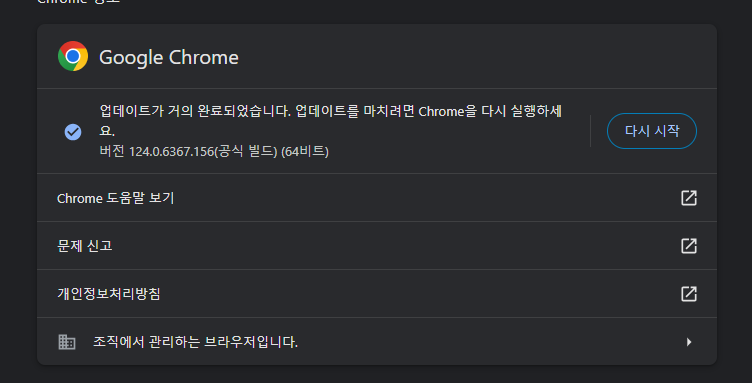

확인하시면 버전 124.0.6367 버전임을 확인할 수 있습니다

https://googlechromelabs.github.io/chrome-for-testing/

이 링크에서

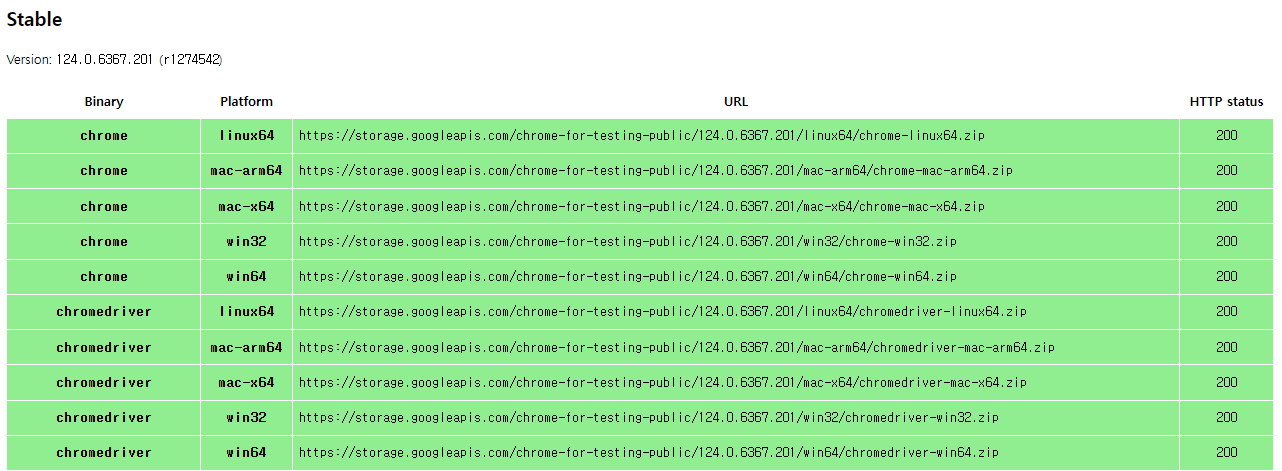

stable의 chromedriver win64의 링크를 복사해서 접속하면 설치가 완료 된다

설치가 완료되었으면 압축을 풀면 된다

경로가 생각보다 복잡해서

저는 문서 파일에 저장해두었습니다.

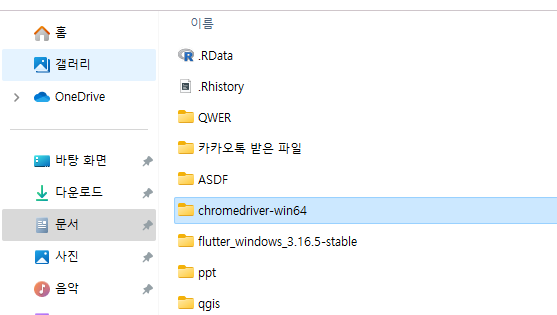

그 폴더 들어가시면 chromedriver.exe가 있다면 설치 완료입니다.

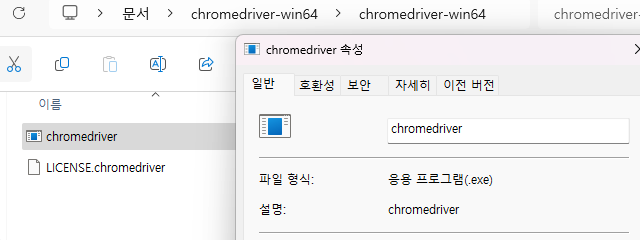

## 아나콘다 설치 

https://www.youtube.com/watch?v=YNej6WeVpD4